In [1]:
# 0. 작업 준비
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch.utils import data
from torchvision import datasets, transforms, utils
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

tr_ds = datasets.MNIST(root='../data/',
                              train=True,
                              download=True,
                              transform=transform)

100%|██████████| 9.91M/9.91M [00:32<00:00, 301kB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:05<00:00, 284kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.27MB/s]


In [4]:
BATCH_SIZE = 60000
tr_ds_loader = torch.utils.data.DataLoader(
    dataset = tr_ds,
    batch_size = BATCH_SIZE,
    shuffle = False
)
img, _ = next(iter(tr_ds_loader))

In [5]:
img.shape, img.mean(), img.std()

(torch.Size([60000, 1, 28, 28]), tensor(0.1307), tensor(0.3081))

In [6]:
BATCH_SIZE=64
EPOCHS=10

In [8]:
# 데이터 수정 (노이즈 삽입)
# 1. 데이터 준비
transform = transforms.Compose([
    transforms.ToTensor()
])

tr_ds_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        root='../data/',
        train=True,
        download=False,
        transform=transform,
    ),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)
tt_ds_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        root='../data/',
        train=False,
        download=False,
        transform=transform,
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [9]:
tr_ds.data[:1].shape

torch.Size([1, 28, 28])

In [10]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [11]:
autoencoder = AutoEncoder().to(DEVICE)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [12]:
v_img = tr_ds.data[:5].view(-1, 28*28)
v_img = v_img.type(torch.FloatTensor) / 255.
v_img.shape

torch.Size([5, 784])

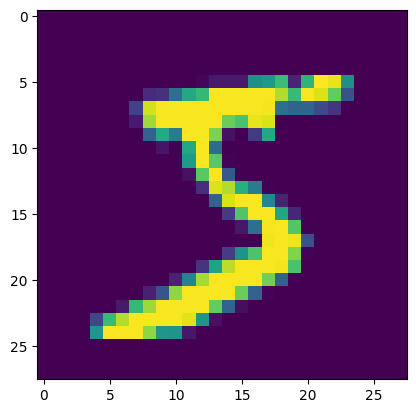

In [16]:
plt.imshow(v_img[0].view(28, 28) * 255)

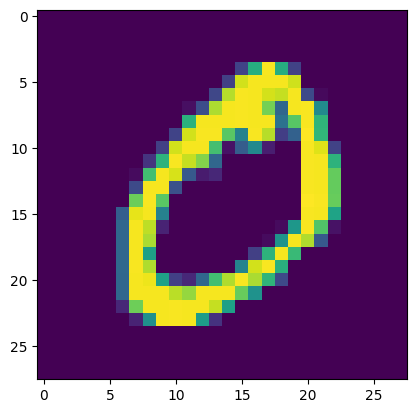

In [17]:
plt.imshow(v_img[1].view(28, 28) * 255)

In [18]:
def train(model, tr_ds_loader):
    model.train()
    for (x, y) in tr_ds_loader:
        data = x.view(-1, 28*28).to(DEVICE)
        target = x.view(-1, 28*28).to(DEVICE)
        label = y.to(DEVICE)

        _, decoded = model(data)

        loss = criterion(decoded, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [19]:
v_img.data.numpy().shape # v_img = tr_ds.data[:5].view(-1, 28*28)

(5, 784)

1회


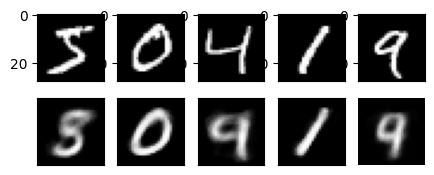

2회


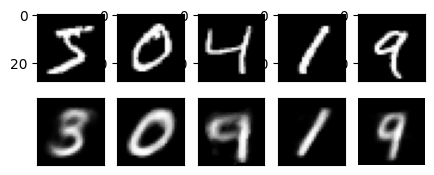

3회


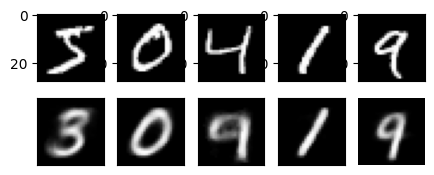

4회


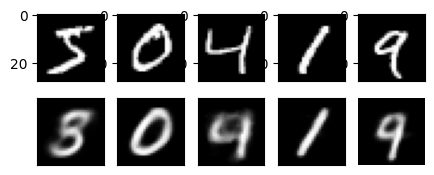

5회


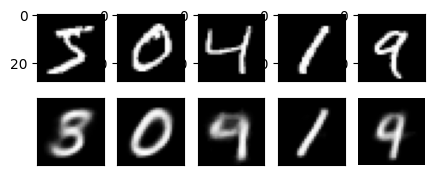

6회


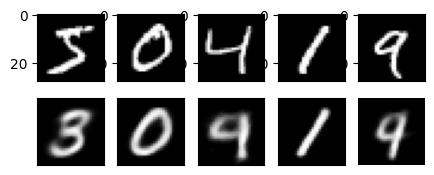

7회


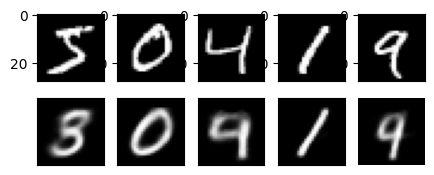

8회


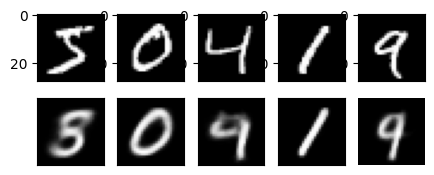

9회


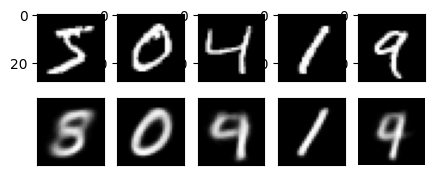

10회


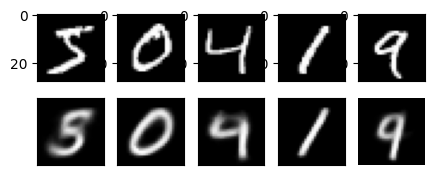

In [20]:
for epoch in range(1, EPOCHS+1):
    train(autoencoder, tr_ds_loader)

    tt_x = v_img.to(DEVICE)
    _, dc_data = autoencoder(tt_x)

    fig, a = plt.subplots(2, 5, figsize=(5, 2))
    print(f'{epoch}회')

    for i in range(5):
        img = v_img.data.numpy()[i].reshape(28, 28)
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(())
        a[1][i].set_yticks(())
    
    for i in range(5):
        img = dc_data.to('cpu').data.numpy()[i].reshape(28, 28)
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.axis('off')
    plt.show()